# RUN BOX PREDICTIONS

In [1]:
PATH_TO_MODEL = "/home/mehdi/ultralytics/runs/detect/train8/weights/best.pt"
PATH_TO_IMAGES = "/home/mehdi/ultralytics/unhycos_data/"

In [2]:
import os
from ultralytics import YOLO

# Load model
model = YOLO(PATH_TO_MODEL)
list_of_results = model.predict(PATH_TO_IMAGES, verbose=True)


image 1/29 /home/mehdi/ultralytics/unhycos_data/WhatsApp Image 2024-05-28 at 09.16.23.jpeg: 640x480 57 objects, 106.0ms
image 2/29 /home/mehdi/ultralytics/unhycos_data/WhatsApp Image 2024-05-28 at 09.16.24.jpeg: 640x480 70 objects, 43.6ms
image 3/29 /home/mehdi/ultralytics/unhycos_data/WhatsApp Image 2024-05-28 at 09.16.25 (1).jpeg: 640x480 114 objects, 45.3ms
image 4/29 /home/mehdi/ultralytics/unhycos_data/WhatsApp Image 2024-05-28 at 09.16.25.jpeg: 640x480 55 objects, 47.0ms
image 5/29 /home/mehdi/ultralytics/unhycos_data/WhatsApp Image 2024-05-28 at 09.16.26.jpeg: 640x480 100 objects, 30.0ms
image 6/29 /home/mehdi/ultralytics/unhycos_data/WhatsApp Image 2024-05-28 at 09.16.27 (1).jpeg: 640x480 101 objects, 12.5ms
image 7/29 /home/mehdi/ultralytics/unhycos_data/WhatsApp Image 2024-05-28 at 09.16.27 (2).jpeg: 480x640 45 objects, 63.0ms
image 8/29 /home/mehdi/ultralytics/unhycos_data/WhatsApp Image 2024-05-28 at 09.16.27.jpeg: 640x480 52 objects, 16.3ms
image 9/29 /home/mehdi/ultralyt

# SHOW BOX PREDICTION RESULTS

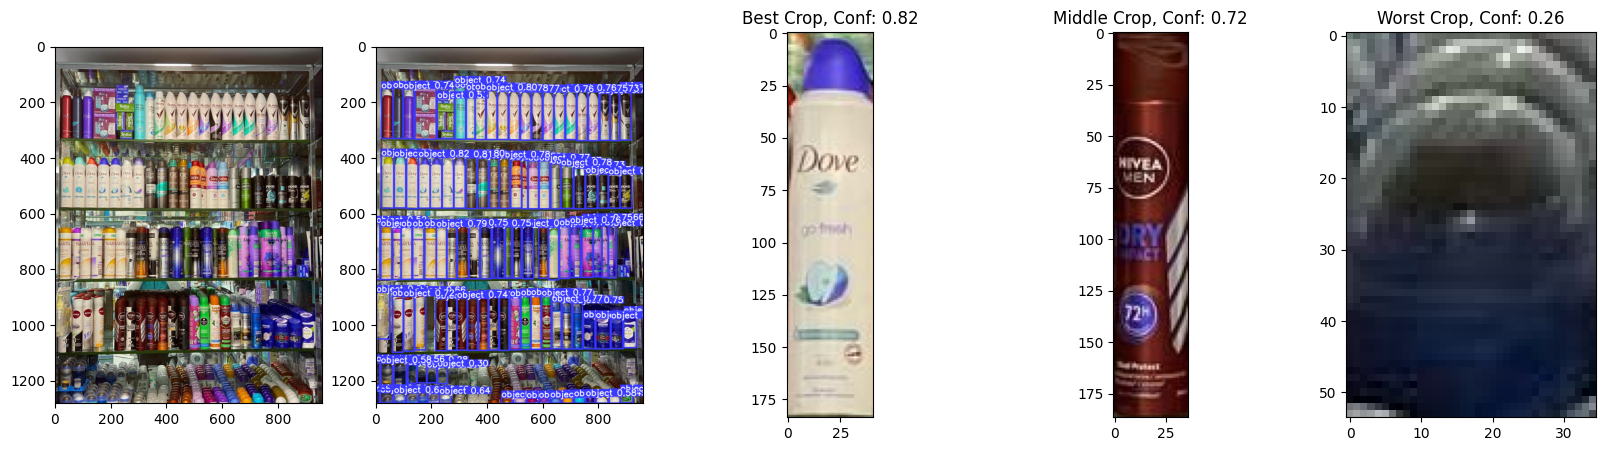

In [3]:
from matplotlib import pyplot as plt

RESULT_IMAGE_INDEX = 2
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

whole_image = list_of_results[RESULT_IMAGE_INDEX].orig_img
best_box = list_of_results[RESULT_IMAGE_INDEX].boxes.xyxy[0]
best_crop_image = whole_image[
    int(best_box[1]) : int(best_box[3]), int(best_box[0]) : int(best_box[2])
]
worst_box = list_of_results[RESULT_IMAGE_INDEX].boxes.xyxy[-1]
worst_crop_image = whole_image[
    int(worst_box[1]) : int(worst_box[3]), int(worst_box[0]) : int(worst_box[2])
]
middle_box = list_of_results[RESULT_IMAGE_INDEX].boxes.xyxy[
    len(list_of_results[RESULT_IMAGE_INDEX].boxes.xyxy) // 2
]
middle_crop_image = whole_image[
    int(middle_box[1]) : int(middle_box[3]), int(middle_box[0]) : int(middle_box[2])
]
ax[0].imshow(whole_image)
ax[1].imshow(list_of_results[RESULT_IMAGE_INDEX].plot())
ax[2].imshow(best_crop_image)
ax[2].set_title(
    f"Best Crop, Conf: {list_of_results[RESULT_IMAGE_INDEX].boxes.conf[0].item():.2f}"
)
ax[3].imshow(middle_crop_image)
ax[3].set_title(
    f"Middle Crop, Conf: {list_of_results[RESULT_IMAGE_INDEX].boxes.conf[len(list_of_results[RESULT_IMAGE_INDEX].boxes.xyxy) // 2].item():.2f}"
)
ax[4].imshow(worst_crop_image)
ax[4].set_title(
    f"Worst Crop, Conf: {list_of_results[RESULT_IMAGE_INDEX].boxes.conf[-1].item():.2f}"
)
plt.show()

### Saving the crops

In [4]:
from tqdm import tqdm

for i, result in tqdm(enumerate(list_of_results)):
    for j, box in enumerate(result.boxes.xyxy):
        crop_image = result.orig_img[
            int(box[1]) : int(box[3]), int(box[0]) : int(box[2])
        ]
        crop_image_path = os.path.join(
            "/home/mehdi/dalia-ml/crops", f"crop_{i}_{j}.jpg"
        )
        plt.imsave(crop_image_path, crop_image)

29it [00:06,  4.53it/s]


# Generate Embeddings

In [5]:
# Load embeddings model
import torch

dinov2_vitb14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")
dinov2_vitb14 = dinov2_vitb14.to("cuda")

Using cache found in /home/mehdi/.cache/torch/hub/facebookresearch_dinov2_main
/home/mehdi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/mehdi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/mehdi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /home/mehdi/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:04<00:00, 77.1MB/s] 


In [6]:
import torch.nn.functional as F

list_of_features_patch_norm = []
list_of_cropped_images = []
for results in tqdm(list_of_results, leave=False):
    for box, conf in tqdm(zip(results.boxes.xyxy, results.boxes.conf), leave=False):
        if conf < 0.75:
            continue
        bestCropImage = results.orig_img[
            int(box[1]) : int(box[3]), int(box[0]) : int(box[2])
        ]
        list_of_cropped_images.append(bestCropImage)
        tensor_cropped_image = (
            torch.from_numpy(bestCropImage).to("cuda").permute(2, 0, 1).unsqueeze(0).float()
        )
        tensor_cropped_image = F.interpolate(tensor_cropped_image, size=(224, 224))
        features = dinov2_vitb14.forward_features(tensor_cropped_image)
        features = features['x_norm_patchtokens']
        features = features.permute(0, 2, 1)
        features = features.cpu().detach().numpy()
        list_of_features_patch_norm.append(features)

In [11]:
import numpy as np

mask_dim = (224 / dinov2_vitb14.patch_size, 224 / dinov2_vitb14.patch_size) 
list_of_features_patch_norm = np.array(list_of_features_patch_norm).squeeze()
list_of_features_patch_norm.shape

(1011, 768, 256)

## Display embeddings

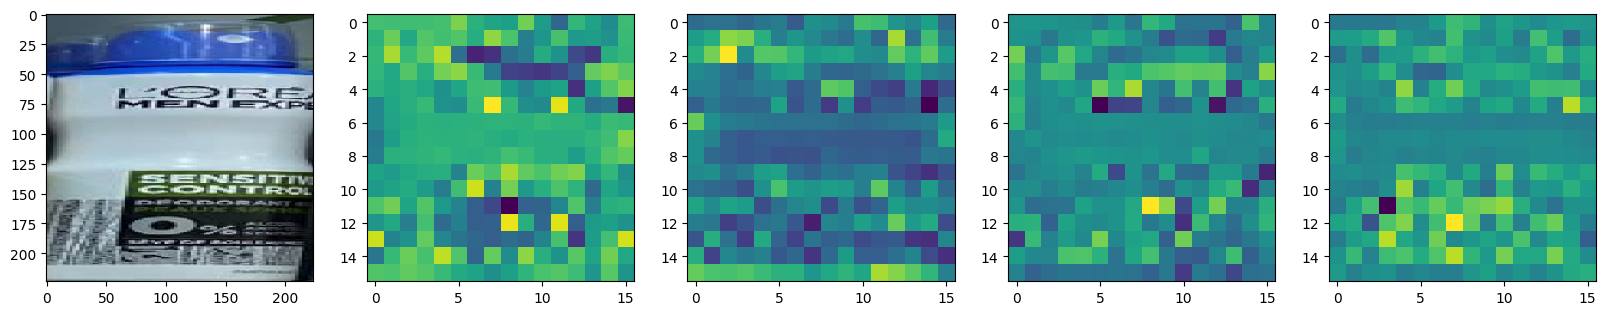

In [ ]:
from matplotlib import pyplot as plt

CROP_INDEX = 0

reshaped_features = list_of_features_patch_norm.reshape(
    list_of_features_patch_norm.shape[0], dinov2_vitb14.num_features, int(mask_dim[0]), int(mask_dim[1])
)
image = list_of_cropped_images[CROP_INDEX]
resized_images = (
    F.interpolate(
        torch.from_numpy(image).to("cuda").permute(2, 0, 1).unsqueeze(0).float() / 255,
        size=(224, 224),
    )
    .cpu()
    .detach()
    .numpy()
)
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(resized_images.squeeze().transpose(1, 2, 0))
ax[1].imshow(reshaped_features[CROP_INDEX, 0])
ax[2].imshow(reshaped_features[CROP_INDEX, 1])
ax[3].imshow(reshaped_features[CROP_INDEX, 2])
ax[4].imshow(reshaped_features[CROP_INDEX, -1])

## Working with clusterings

In [13]:
# Generating averaged features
import torch.nn.functional as F

list_of_features = []
list_of_cropped_images = []
for results in tqdm(list_of_results, leave=False):
    for box, conf in tqdm(zip(results.boxes.xyxy, results.boxes.conf), leave=False):
        if conf < 0.75:
            continue
        bestCropImage = results.orig_img[
            int(box[1]) : int(box[3]), int(box[0]) : int(box[2])
        ]
        list_of_cropped_images.append(bestCropImage)
        tensor_cropped_image = (
            torch.from_numpy(bestCropImage)
            .to("cuda")
            .permute(2, 0, 1)
            .unsqueeze(0)
            .float()
        )
        # closest size to images that is divisible by 14
        tensor_cropped_image = F.interpolate(
            tensor_cropped_image,
            size=(
                int(
                    round(tensor_cropped_image.shape[2] / dinov2_vitb14.patch_size)
                    * dinov2_vitb14.patch_size
                ),
                int(
                    round(tensor_cropped_image.shape[3] / dinov2_vitb14.patch_size)
                    * dinov2_vitb14.patch_size
                ),
            ),
        )
        features = dinov2_vitb14(tensor_cropped_image)
        features = features.cpu().detach().numpy()
        list_of_features.append(features)
list_of_features = np.array(list_of_features).squeeze()

In [14]:
list_of_features.shape

(1011, 768)

### Clustering the features

In [85]:
from sklearn.cluster import HDBSCAN

dbscan = HDBSCAN(metric="cosine", min_cluster_size=4)
dbscan.fit(list_of_features)

HDBSCAN(metric='cosine', min_cluster_size=4)

## Visualizing the clustered features

In [86]:
import numpy as np

np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([806,  25,   8,   4,   5,   8,  10,   6,  12,   6, 117,   4]))

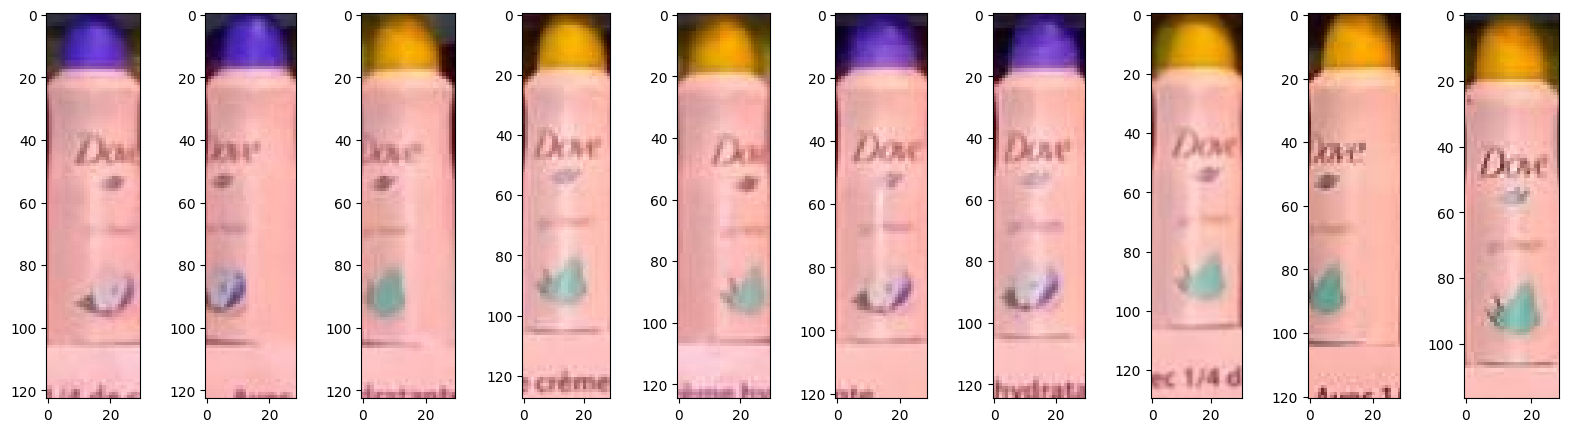

In [94]:
LABEL_INDEX = 7

indices_of_label = np.where(dbscan.labels_ == LABEL_INDEX)[0]

fig, ax = plt.subplots(1, 10, figsize=(20, 5))

for i, index in enumerate(indices_of_label[:10]):
    ax[i].imshow(list_of_cropped_images[index])

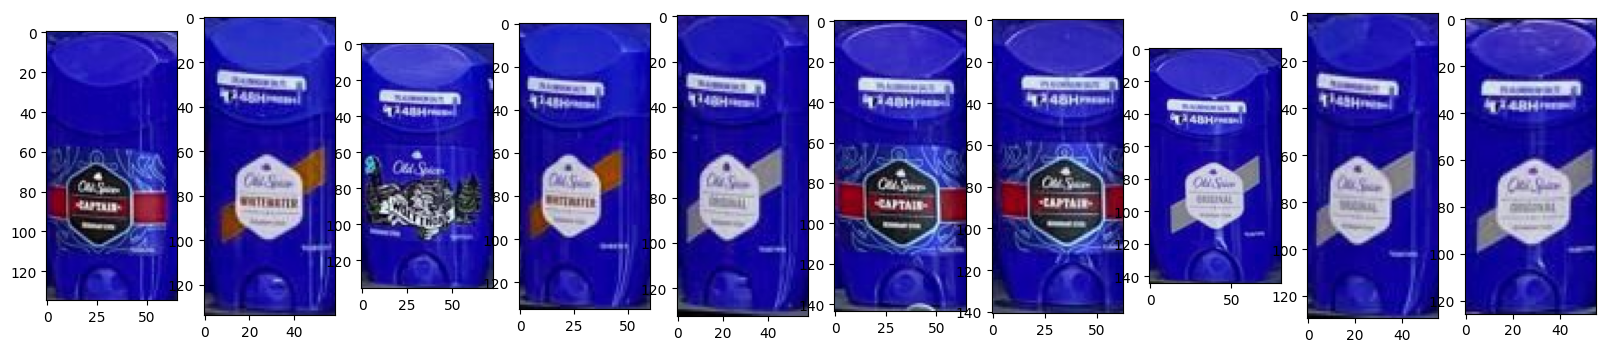

In [88]:
LABEL_INDEX = 0

indices_of_label = np.where(dbscan.labels_ == LABEL_INDEX)[0]

fig, ax = plt.subplots(1, 10, figsize=(20, 5))

for i, index in enumerate(indices_of_label[:10]):
    ax[i].imshow(list_of_cropped_images[index])